## Problem1-3

In [1]:
from torchvision import transforms
from dataset import Face_Dataset, DataLoader

test_transform = transforms.Compose([transforms.ToTensor()])
test_dataset = Face_Dataset('../hw3_data/face/test', test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)


In [2]:
import torch 
import numpy as np

from model.my_model import ResNet18_VAE
from model.vanilla_vae import VanillaVAE

latent_dim = 64

model = VanillaVAE(3, latent_dim)
model.load_state_dict(torch.load('./result/best_vanilla_vae.pth'))
model.eval();

batch = next(iter(test_dataloader))
out_imgs = model(batch)[0]
print(batch.shape, out_imgs.shape)

torch.Size([10, 3, 64, 64]) torch.Size([10, 3, 64, 64])


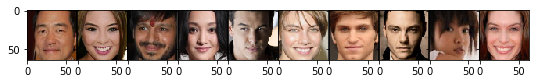

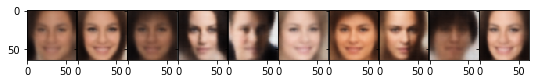

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

## origin images
fig = plt.figure(figsize=(9., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )
for ax, im in zip(grid, batch.detach().cpu().numpy()):
    # Iterating over the grid returns the Axes.
    im = np.moveaxis(im,0,-1)
    ax.imshow(im)
plt.show()

## reconstruct images
fig = plt.figure(figsize=(9., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )
for ax, im in zip(grid, out_imgs.detach().cpu().numpy()):
    # Iterating over the grid returns the Axes.
    im = np.moveaxis(im,0,-1)
    ax.imshow(im)
plt.show()

In [4]:

for i in range(10):
    mse = ((out_imgs[i].detach().numpy() - batch[i].detach().numpy())**2).mean()
    print(mse)


0.0064817057
0.009427161
0.008262185
0.0146364635
0.017597357
0.01622201
0.013408713
0.021691969
0.013301797
0.0072764237


## Problem1-4

In [5]:
from model.my_model import ResNet18_VAE
from model.vanilla_vae import VanillaVAE

import torch
import numpy as np

In [6]:
model = VanillaVAE(3, latent_dim)
model.load_state_dict(torch.load('./result/best_vanilla_vae.pth'))
model.eval();

In [7]:
np.random.seed(87)
latent = torch.tensor(np.random.normal(size=(32,latent_dim))).float()

out_imgs = model.decode(latent)
out_imgs.shape

torch.Size([32, 3, 64, 64])

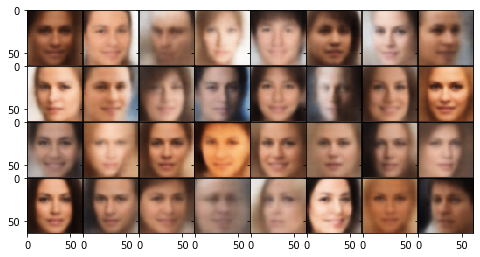

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

fig = plt.figure(figsize=(8., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.01,  # pad between axes in inch.
                 )

for ax, im in zip(grid, out_imgs.detach().cpu().numpy()):
    # Iterating over the grid returns the Axes.
    im = np.moveaxis(im,0,-1)
    ax.imshow(im)

plt.show()

## Problem1-5

In [15]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import torch
import numpy as np
import pandas as pd

#from utils import xx

class Face_Dataset_Test(Dataset):
    def __init__(self, path=None, transform=None, test_label='Male'):
        assert path is not None
        self.path = path 
        test_csv = pd.read_csv(f'{path}/test.csv')
        self.data = test_csv['image_name'].tolist()
        self.labels = (test_csv[test_label] > 0.5).tolist()
        self.transform = transform
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.path+'/test/'+self.data[idx]).convert('RGB') 
        if self.transform is not None:
            img = self.transform(img)

        img_in = img_out = img
        label = self.labels[idx]
        
        return img_in, label
    
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = Face_Dataset_Test('../hw3_data/face/', transform, 'Brown_Hair')
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             num_workers=8)

In [16]:
from model.my_model import ResNet18_VAE
from model.vanilla_vae import VanillaVAE

latent_dim = 64

with torch.no_grad():
    model = VanillaVAE(3,latent_dim)
    model.load_state_dict(torch.load('./result/best_vanilla_vae.pth'))
    model.eval()

    latents = []
    labels = []
    for i,(imgs,lbls) in enumerate(test_dataloader):
        latent = model.encode(imgs)[0]
        latents.append(latent.detach().cpu())
        labels.append(lbls.detach().cpu())
        print(f'\t[{i+1}/{len(test_dataloader)}] ', end='   \r')
        
latents = torch.cat(latents,dim=0).numpy()
labels = torch.cat(labels,dim=0).numpy()

In [17]:
# TSNE
import numpy as np
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(latents)
y = labels.astype(np.int)

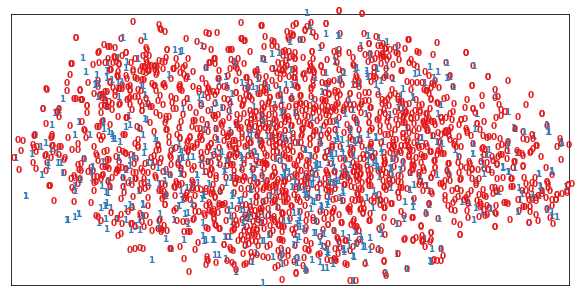

In [18]:
# Plot
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
plt.figure(figsize=(10, 5))
for i in range(X_norm.shape[0]):
    plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), 
             fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()
